In [4]:
import numpy as np
import time
import os
import pickle
import matplotlib.pyplot as plt
import scipy

In [5]:
class Empty:
    """
    Empty class used for the arguments.
    """
    pass

In [6]:
args = Empty()

In [7]:
def get_samples(args):
    """
    Obtain samples.
    """
    noise_covariance = args.variance*np.eye(args.d)
    mean_1 = np.zeros(args.d)
    mean_2 = np.zeros(args.d)
    mean_2[0] = args.mean_diff
    X1 = np.random.multivariate_normal(mean_1,noise_covariance,args.n_samples)
    X2 = np.random.multivariate_normal(mean_2,noise_covariance,args.n_samples)
    return X1, X2

In [8]:
def median_distance(X1,X2):
    """
    Compute median distances between points in X1 and X2, to apply median criterion for the bandwidth.
    """
    length_1 = X1.shape[0]
    length_2 = X2.shape[0]
    X1_expanded = np.tile(np.expand_dims(X1, axis=1),(1,length_2,1))
    X2_expanded = np.tile(np.expand_dims(X2, axis=0),(length_1,1,1))
    distances = np.linalg.norm(X1_expanded-X2_expanded,axis=2)
    return np.median(distances)

In [9]:
def kernel_eval(X1,X2,bw,args):
    """
    Compute RBF kernel evaluation matrix for sample sets X1 and X2, with bandwidth bw.
    """
    n_samples_1 = X1.shape[0]
    n_samples_2 = X2.shape[0]
    X1_expanded = np.tile(np.expand_dims(X1, axis=1),(1,n_samples_2,1))
    X2_expanded = np.tile(np.expand_dims(X2, axis=0),(n_samples_1,1,1))
    distances = np.linalg.norm(X1_expanded-X2_expanded,axis=2)
    if args.n_bws == 1:
        if args.kernel == 'rbf':
            return np.exp(-(distances/bw)**2)
        else:
            return (1+(distances/bw)**2)**(-2)
    else:
        log_bw_vec = np.linspace(np.log(bw) - np.log(args.bw_logratio),np.log(bw) + np.log(args.bw_logratio),num=args.n_bws)
        bw_vec = np.exp(log_bw_vec)
        eval_matrix = np.zeros((n_samples_1,n_samples_2))
        for i in range(args.n_bws):
            if args.kernel == 'rbf':
                eval_matrix = eval_matrix + np.exp(-(distances/bw_vec[i])**2)/args.n_bws
            else:
                eval_matrix = eval_matrix + (1+(distances/bw)**2)**(-2)/args.n_bws
        return eval_matrix

In [8]:
def krd(X1,X2,bw,args):
    """
    Compute regularized kernel Renyi divergence with RBF kernel and bandwidth bw, corresponding to samples X1, X2.
    """
    K_xx = kernel_eval(X1,X1,bw,args)
    K_yy = kernel_eval(X2,X2,bw,args)
    K_xy = kernel_eval(X1,X2,bw,args)
    K_yx = np.transpose(K_xy)
    hatSigma_p = np.concatenate((np.concatenate((K_xx, K_xy), axis=1),
                             np.zeros((args.n_samples,2*args.n_samples))),axis=0)/args.n_samples
    hatSigma_q = np.concatenate((np.zeros((args.n_samples,2*args.n_samples)),
                                 np.concatenate((K_yx, K_yy), axis=1)),axis=0)/args.n_samples
    hatSigma_q_reg = hatSigma_q + args.lmbda*np.eye(2*args.n_samples)
    hatSigma_p_eva, hatSigma_p_eve = np.linalg.eig(hatSigma_p)
    hatSigma_q_reg_eva, hatSigma_q_reg_eve = np.linalg.eig(hatSigma_q_reg)
    q_exponent = (1-args.alpha)/(2*args.alpha)
    hatSigma_q_reg_power = np.matmul(np.matmul(hatSigma_q_reg_eve,np.diag(hatSigma_q_reg_eva**q_exponent)),np.linalg.inv(hatSigma_q_reg_eve))
    intermediate_matrix = np.matmul(np.matmul(hatSigma_q_reg_power,hatSigma_p),hatSigma_q_reg_power)
    intermediate_matrix_eva, _ = np.linalg.eig(intermediate_matrix)
    krd_p_q = np.log(np.sum(intermediate_matrix_eva**args.alpha))/(args.alpha-1)
    return krd_p_q

In [135]:
def analytic_variance_gaussian_mechanism(args,sensitivity): 
    #Citation: https://proceedings.mlr.press/v80/balle18a/balle18a.pdf
    if sensitivity == 0:
        return 0.01**2
    else:
        sigma = 0.01
        iterations = 0
        while not analytic_variance_condition(args,sensitivity,sigma):
            sigma = sigma*1.01
            iterations += 1
        print(f'Number of iterations: {iterations}. Final sigma: {sigma}.')
        return sigma**2

In [17]:
def analytic_variance_condition(args,sensitivity,sigma):
    Phi = lambda x: scipy.stats.norm.cdf(x)
    if Phi(sensitivity/(2*sigma) - args.epsilon*sigma/sensitivity) - np.exp(args.epsilon)*Phi(-sensitivity/(2*sigma) - args.epsilon*sigma/sensitivity) <= args.delta:
        return True
    else:
        return False

In [11]:
def lmbda_value_epsilon_delta(args):
    lmbda_value = 2*args.delta*np.exp(-args.epsilon)
    print(f'Lambda for epsilon={args.epsilon} and delta={args.delta}: {lmbda_value}.')
    return lmbda_value

In [58]:
def exact_rd(args):
    #https://mast.queensu.ca/~fady/Journal/GiAlLi13.pdf
    return 0.5*args.alpha*args.mean_diff**2/args.variance

In [70]:
"""
See variances and Renyi divergences for given alpha and sensitivities
"""
alpha_vec = [2,6,12]
mean_diff_vec = [0,3,7,10]

alpha_size = len(alpha_vec)
mean_diff_size = len(mean_diff_vec)

for mean_diff_id in range(mean_diff_size):
    for alpha_id in range(alpha_size):
        args.mean_diff = mean_diff_vec[mean_diff_id]
        args.alpha = alpha_vec[alpha_id]
        args.variance = analytic_variance_gaussian_mechanism(args,args.mean_diff)
        args.rd = exact_rd(args)
        print('s='+f'{args.mean_diff}, '+'alpha='+f'{args.alpha}: '+'variance: '+f'{args.variance:.4f}, '+'RD: '+f'{args.rd:.4f}')

Number of iterations: 1. Final sigma: 0.0102.
s=0, alpha=2: variance: 0.0001, RD: 0.0000
Number of iterations: 1. Final sigma: 0.0102.
s=0, alpha=6: variance: 0.0001, RD: 0.0000
Number of iterations: 1. Final sigma: 0.0102.
s=0, alpha=12: variance: 0.0001, RD: 0.0000
Number of iterations: 289. Final sigma: 3.0580856102171303.
s=3, alpha=2: variance: 9.3519, RD: 0.9624
Number of iterations: 289. Final sigma: 3.0580856102171303.
s=3, alpha=6: variance: 9.3519, RD: 2.8871
Number of iterations: 289. Final sigma: 3.0580856102171303.
s=3, alpha=12: variance: 9.3519, RD: 5.7742
Number of iterations: 332. Final sigma: 7.165673649595699.
s=7, alpha=2: variance: 51.3469, RD: 0.9543
Number of iterations: 332. Final sigma: 7.165673649595699.
s=7, alpha=6: variance: 51.3469, RD: 2.8629
Number of iterations: 332. Final sigma: 7.165673649595699.
s=7, alpha=12: variance: 51.3469, RD: 5.7258
Number of iterations: 350. Final sigma: 10.234346501391236.
s=10, alpha=2: variance: 104.7418, RD: 0.9547
Number

In [11]:
def gaussian_mechanism_different(lmbda_vec,alpha_vec,mean_diff_vec,epsilon_vec,delta_vec,n_samples_vec,args):
    """
    Compute RKRD for all combinations given by lists of lambda, alpha, sensitivity and number of samples. 
    For each sensitivity value, epsilon_vec and delta_vec contain the values of epsilon and delta used to compute the 
    variance according to analytic_variance_gaussian_mechanism.
    """
    resdir = os.path.join('res', args.name)
    if not os.path.exists(resdir):
        os.makedirs(resdir)

    lmbda_size = len(lmbda_vec)
    alpha_size = len(alpha_vec)
    mean_diff_size = len(mean_diff_vec)
    n_samples_size = len(n_samples_vec)

    filename = args.name+'_'+str(args.d)+'_'+str(args.n_computations)+'_'+args.kernel+'_'+str(args.n_bws)+'_'+str(args.bw_logratio)+'_'+str(args.analytic_variance)+'_'+str(lmbda_vec[0])+'_'+str(lmbda_vec[lmbda_size-1])+'_'+str(alpha_vec)+'_'+str(mean_diff_vec)+'_'+str(epsilon_vec)+'_'+str(delta_vec)+'_'+str(n_samples_vec)+'_'+str(args.theory)+'.pkl'
    fname = os.path.join(resdir,filename)
    if os.path.exists(fname):
        print('Results file already exists.')
        res = pickle.load(open(fname, 'rb'))
        return res
    else:
        theory_tensor = np.zeros((alpha_size,mean_diff_size))
        for mean_diff_id in range(mean_diff_size):
            for alpha_id in range(alpha_size):
                args.mean_diff = mean_diff_vec[mean_diff_id]
                args.epsilon = epsilon_vec[mean_diff_id]
                args.delta = delta_vec[mean_diff_id]
                args.alpha = alpha_vec[alpha_id]
                if args.analytic_variance:
                    args.variance = analytic_variance_gaussian_mechanism(args,args.mean_diff)
                else:
                    args.variance = 1
                theory_tensor[alpha_id,mean_diff_id] = exact_rd(args)
        avg_tensor = np.zeros((lmbda_size,alpha_size,mean_diff_size,n_samples_size))
        std_tensor = np.zeros((lmbda_size,alpha_size,mean_diff_size,n_samples_size))
        for n_samples_id in range(n_samples_size):
            for mean_diff_id in range(mean_diff_size):
                for alpha_id in range(alpha_size):
                    for lmbda_id in range(lmbda_size):
                        args.n_samples = n_samples_vec[n_samples_id]
                        args.mean_diff = mean_diff_vec[mean_diff_id]
                        args.epsilon = epsilon_vec[mean_diff_id]
                        args.delta = delta_vec[mean_diff_id]
                        args.alpha = alpha_vec[alpha_id]
                        args.lmbda = lmbda_vec[lmbda_id]

                        if args.analytic_variance:
                            args.variance = analytic_variance_gaussian_mechanism(args,args.mean_diff)
                        else:
                            args.variance = 1
                        
                        X1, X2 = get_samples(args)
                        bw = median_distance(X1,X2)
                        print(f'Bandwidth: {bw}.')

                        krd_vec = np.zeros(args.n_computations)
                        for i in range(args.n_computations):
                            X1, X2 = get_samples(args)
                            krd_p_q = np.real(krd(X1,X2,bw,args))
                            krd_vec[i] = krd_p_q
                        avg_tensor[lmbda_id,alpha_id,mean_diff_id,n_samples_id] = np.mean(krd_vec)
                        std_tensor[lmbda_id,alpha_id,mean_diff_id,n_samples_id] = np.std(krd_vec)
                        print(f'Average KRD for lambda={args.lmbda}, alpha={args.alpha}, n={args.n_samples}, mean_diff={args.mean_diff}, d={args.d}: {np.mean(krd_vec)}. Std KRD: {np.std(krd_vec)}.')
                        print(f'Theory: {theory_tensor[alpha_id,mean_diff_id]}.')
        res = {
            'avg': avg_tensor,
            'std': std_tensor,
            'theory': theory_tensor
        }
        pickle.dump(res, open(fname, 'wb'))
        return res

Results file already exists.
Figure for mean_diff=0 done.
Figure for mean_diff=10 done.
Figure for mean_diff=10 done.
Figure for mean_diff=10 done.


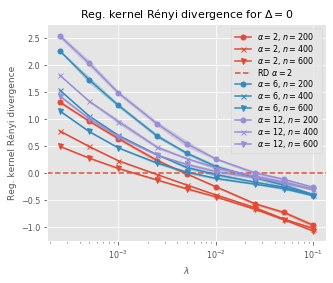

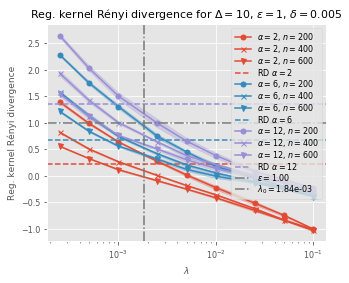

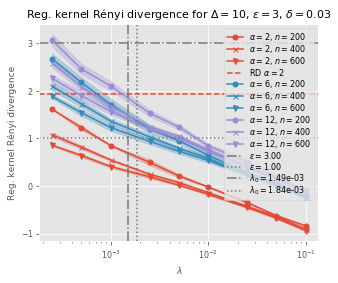

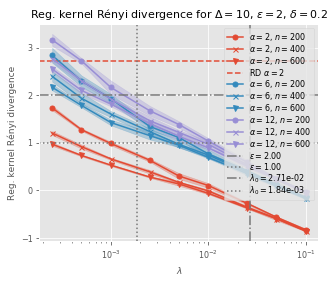

In [154]:
SMALL_SIZE = 8
MEDIUM_SIZE = 9
BIGGER_SIZE = 11
plt.style.use('ggplot')

lmbda_vec = [0.00025,0.0005,0.001,0.0025,0.005,0.01,0.025,0.05,0.1]
alpha_vec = [2,6,12]
mean_diff_vec = [0,10,10,10]
epsilon_vec = [1,1,3,2]
delta_vec = [0.005,0.005,0.03,0.2]
n_samples_vec = [200,400,600]
lmbda_size = len(lmbda_vec)
alpha_size = len(alpha_vec)
mean_diff_size = len(mean_diff_vec)
n_samples_size = len(n_samples_vec)

args.d = 30
args.n_computations = 5
args.name = 'gaussian_mechanism_different'
args.n_bws = 1
args.bw_logratio = 2
args.kernel = 'rbf'
args.analytic_variance = True
args.theory = True

color_list = np.array(plt.rcParams['axes.prop_cycle'])
marker_list = ['o','x','v']

res = gaussian_mechanism_different(lmbda_vec,alpha_vec,mean_diff_vec,epsilon_vec,delta_vec,n_samples_vec,args)

if not os.path.exists('figures'):
    os.makedirs('figures')

for mean_diff_id in range(mean_diff_size):
    args.mean_diff = mean_diff_vec[mean_diff_id]
    args.epsilon = epsilon_vec[mean_diff_id]
    args.delta = delta_vec[mean_diff_id]
    plt.figure(figsize=(5,4))
    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    color_id = 0
    for alpha_id in range(alpha_size):
        for n_samples_id in range(n_samples_size):
            color_code = color_list[color_id]['color']
            line_marker = marker_list[n_samples_id]
            plt.semilogx(lmbda_vec, res['avg'][:,alpha_id,mean_diff_id,n_samples_id], label=r'$\alpha=$'+f'{alpha_vec[alpha_id]}, '+r'$n=$'+f'{n_samples_vec[n_samples_id]}', marker=line_marker, markersize=5, color=color_code)
            lower_b = res['avg'][:,alpha_id,mean_diff_id,n_samples_id]-res['std'][:,alpha_id,mean_diff_id,n_samples_id]
            upper_b = res['avg'][:,alpha_id,mean_diff_id,n_samples_id]+res['std'][:,alpha_id,mean_diff_id,n_samples_id]
            plt.fill_between(lmbda_vec, lower_b, upper_b, alpha=.3, color=color_code)
        if args.theory and (alpha_id != 2 or mean_diff_id == 1) and (alpha_id != 1 or mean_diff_id == 1):    
            plt.axhline(y=res['theory'][alpha_id,mean_diff_id], color=color_list[color_id]['color'], linestyle='dashed', label=r'RD $\alpha=$'+f'{alpha_vec[alpha_id]}')
        color_id += 1
    if mean_diff_id != 0:
        plt.axhline(y=args.epsilon, color=color_list[color_id]['color'], linestyle='dashdot', label=r'$\epsilon=$'+f'{args.epsilon:.2f}')
        if args.epsilon != epsilon_vec[0]:
            plt.axhline(y=epsilon_vec[0], color=color_list[color_id]['color'], linestyle=':', label=r'$\epsilon=$'+f'{epsilon_vec[0]:.2f}')
        lmbda_0 = args.delta*np.exp(-args.epsilon)
        plt.axvline(x=lmbda_0, color=color_list[color_id]['color'], linestyle='dashdot', label=r'$\lambda_0=$'+f'{lmbda_0:.2e}')
        lmbda_1 = delta_vec[0]*np.exp(-epsilon_vec[0])
        if lmbda_1 != lmbda_0:
            plt.axvline(x=lmbda_1, color=color_list[color_id]['color'], linestyle=':', label=r'$\lambda_0=$'+f'{lmbda_1:.2e}')
    plt.ylabel('Reg. kernel Rényi divergence')
    plt.xlabel(r'$\lambda$')
    plt.legend()
    plt.legend(labelspacing = 0.0)
    if mean_diff_id != 0:
        plt.title(r'Reg. kernel Rényi divergence for $\Delta=$'+f'{args.mean_diff}, '+r'$\epsilon=$'+f'{args.epsilon}, '+r'$\delta=$'+f'{args.delta}')
    else:
        plt.title(r'Reg. kernel Rényi divergence for $\Delta=$'+f'{args.mean_diff}')
    fig_file = args.name+'_'+str(args.d)+'_'+str(args.n_computations)+'_'+args.kernel+'_'+str(args.n_bws)+'_'+str(args.bw_logratio)+'_'+str(args.analytic_variance)+'_'+str(lmbda_vec[0])+'_'+str(lmbda_vec[lmbda_size-1])+'_'+str(alpha_vec)+'_'+str(args.mean_diff)+'_'+str(args.epsilon)+'_'+str(args.delta)+'_'+str(epsilon_vec[0])+'_'+str(delta_vec[0])+'_'+str(n_samples_vec)+'.pdf'
    plt.savefig(f'figures/'+fig_file, bbox_inches='tight', pad_inches=0.05)
    print(f'Figure for mean_diff={args.mean_diff} done.')

In [12]:
def gaussian_mechanism_validation(lmbda_vec,alpha_vec,mean_diff_vec,n_samples_vec,args):
    """
    Compute RKRD for all combinations given by lists of lambda, alpha, sensitivity and number of samples. 
    """
    resdir = os.path.join('res', args.name)
    if not os.path.exists(resdir):
        os.makedirs(resdir)

    lmbda_size = len(lmbda_vec)
    alpha_size = len(alpha_vec)
    mean_diff_size = len(mean_diff_vec)
    n_samples_size = len(n_samples_vec)

    filename = args.name+'_'+str(args.d)+'_'+str(args.n_computations)+'_'+args.kernel+'_'+str(args.n_bws)+'_'+str(args.bw_logratio)+'_'+str(args.analytic_variance)+'_'+str(args.epsilon)+'_'+str(args.delta)+'_'+str(lmbda_vec[0])+'_'+str(lmbda_vec[lmbda_size-1])+'_'+str(alpha_vec)+'_'+str(mean_diff_vec)+'_'+str(n_samples_vec)+'_'+str(args.theory)+'.pkl'
    fname = os.path.join(resdir,filename)
    if os.path.exists(fname):
        print('Results file already exists.')
        res = pickle.load(open(fname, 'rb'))
        return res
    else:
        theory_tensor = np.zeros((alpha_size,mean_diff_size))
        for mean_diff_id in range(mean_diff_size):
            for alpha_id in range(alpha_size):
                args.mean_diff = mean_diff_vec[mean_diff_id]
                args.alpha = alpha_vec[alpha_id]
                if args.analytic_variance:
                    args.variance = analytic_variance_gaussian_mechanism(args,args.mean_diff)
                else:
                    args.variance = 1
                theory_tensor[alpha_id,mean_diff_id] = exact_rd(args)
        full_tensor = np.zeros((lmbda_size,alpha_size,mean_diff_size,n_samples_size,args.n_computations))
        for n_samples_id in range(n_samples_size):
            for mean_diff_id in range(mean_diff_size):
                for alpha_id in range(alpha_size):
                    for lmbda_id in range(lmbda_size):
                        args.n_samples = n_samples_vec[n_samples_id]
                        args.mean_diff = mean_diff_vec[mean_diff_id]
                        args.alpha = alpha_vec[alpha_id]
                        args.lmbda = lmbda_vec[lmbda_id]

                        if args.analytic_variance:
                            args.variance = analytic_variance_gaussian_mechanism(args,args.mean_diff)
                        else:
                            args.variance = 1
                        
                        X1, X2 = get_samples(args)
                        bw = median_distance(X1,X2)
                        print(f'Bandwidth: {bw}.')

                        krd_vec = np.zeros(args.n_computations)
                        for i in range(args.n_computations):
                            X1, X2 = get_samples(args)
                            krd_p_q = np.real(krd(X1,X2,bw,args))
                            krd_vec[i] = krd_p_q
                            full_tensor[lmbda_id,alpha_id,mean_diff_id,n_samples_id,i] = krd_p_q
                        print(f'Average KRD for lambda={args.lmbda}, alpha={args.alpha}, n={args.n_samples}, mean_diff={args.mean_diff}, d={args.d}: {np.mean(krd_vec)}. Std KRD: {np.std(krd_vec)}.')
                        print(f'Theory: {theory_tensor[alpha_id,mean_diff_id]}.')
        res = {
            'full': full_tensor,
            'theory': theory_tensor
        }
        pickle.dump(res, open(fname, 'wb'))
        return res

Results file already exists.
Figure for mean_diff=10 done.


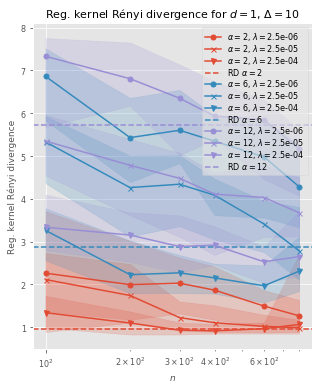

In [121]:
SMALL_SIZE = 8
MEDIUM_SIZE = 9
BIGGER_SIZE = 11
plt.style.use('ggplot')

lmbda_vec = [0.0000025,0.000025,0.00025]
alpha_vec = [2,6,12]
mean_diff_vec = [10] 
n_samples_vec = [100,200,300,400,600,800]
lmbda_size = len(lmbda_vec)
alpha_size = len(alpha_vec)
mean_diff_size = len(mean_diff_vec)
n_samples_size = len(n_samples_vec)

args.d = 1
args.n_computations = 50
args.name = 'krd_validation'
args.n_bws = 1
args.bw_logratio = 2
args.kernel = 'rbf' 
args.analytic_variance = True
args.epsilon = 2
args.delta = 0.02
args.theory = True

color_list = np.array(plt.rcParams['axes.prop_cycle'])
marker_list = ['o','x','v']

res = gaussian_mechanism_validation(lmbda_vec,alpha_vec,mean_diff_vec,n_samples_vec,args)

if not os.path.exists('figures'):
    os.makedirs('figures')

for mean_diff_id in range(mean_diff_size):
    args.mean_diff = mean_diff_vec[mean_diff_id]
    plt.figure(figsize=(5,6))
    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    color_id = 0
    for alpha_id in range(alpha_size):
        for lmbda_id in range(lmbda_size):
            color_code = color_list[color_id]['color']
            line_marker = marker_list[lmbda_id]
            if lmbda_id != 4:
                plt.semilogx(n_samples_vec, np.percentile(res['full'][lmbda_id,alpha_id,mean_diff_id,:,:],50,axis=1), label=r'$\alpha=$'+f'{alpha_vec[alpha_id]}, '+r'$\lambda=$'+f'{lmbda_vec[lmbda_id]:.1e}', marker=line_marker, markersize=5, color=color_code)
            lower_b = np.percentile(res['full'][lmbda_id,alpha_id,mean_diff_id,:,:],25,axis=1)
            upper_b = np.percentile(res['full'][lmbda_id,alpha_id,mean_diff_id,:,:],75,axis=1)
            if lmbda_id != 4:
                plt.fill_between(n_samples_vec, lower_b, upper_b, alpha=.2, color=color_code)
        if args.theory:    
            plt.axhline(y=res['theory'][alpha_id,mean_diff_id], color=color_list[color_id]['color'], linestyle='dashed', label=r'RD $\alpha=$'+f'{alpha_vec[alpha_id]}')
        color_id += 1
    plt.ylabel('Reg. kernel Rényi divergence')
    plt.xlabel(r'$n$')
    plt.legend()
    plt.legend(labelspacing = 0.0, framealpha=0.6)
    plt.title(f'Reg. kernel Rényi divergence for $d={args.d}$, '+r'$\Delta=$'+f'{args.mean_diff}') 
    fig_file = args.name+'_'+str(args.d)+'_'+str(args.n_computations)+'_'+args.kernel+'_'+str(args.n_bws)+'_'+str(args.bw_logratio)+'_'+str(args.analytic_variance)+'_'+str(args.epsilon)+'_'+str(args.delta)+'_'+str(lmbda_vec[0])+'_'+str(lmbda_vec[lmbda_size-1])+'_'+str(alpha_vec)+'_'+str(args.mean_diff)+'_'+str(n_samples_vec)+'.pdf'
    plt.savefig(f'figures/'+fig_file, bbox_inches='tight', pad_inches=0.05)
    print(f'Figure for mean_diff={args.mean_diff} done.')